In [1]:
import sys
import os
sys.path.append('..')
import torchvision.transforms as T

from wildlife_tools.data import WildlifeDataset
from wildlife_tools.inference import KnnClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

import pandas as pd
import itertools
from torch.optim import SGD
from utils.trainer_pl import basic_trainer_pl
from models.template_model import TemplateModel
from utils.triplet_loss_utils import TripletLoss_wildlife

from utils.triplet_loss_utils import KnnClassifier
from wildlife_tools.similarity import CosineSimilarity
from sklearn.metrics import precision_score, recall_score, f1_score

import timm
import torch.nn as nn
from pytorch_lightning import LightningModule
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_lightning import Trainer
import numpy as np
from PIL import Image
import wandb
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from wildlife_datasets import analysis, datasets, loader
from wildlife_tools.features import DeepFeatures
from utils.visualization import query_prediction_results, query_prediction_results_similarity
from data.wildlife_dataset import WildlifeDataModule
from data.raptors_wildlife import Raptors, GoldensWildlife




/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
# Reproduce what combined_datasets does but without config and with local paths.
# this uses CACHE
# create a config dict
config = {}
config['wildlife_name'] = "raptors, BirdIndividualID, ATRW, whaleshark"
config['animal_cat'] = ['bird', 'bird', 'mammal', 'fish']
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/'
config['cache_path']= '/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_multispecies2.csv'
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] = 224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'closed'
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0


cache_df = pd.read_csv(config['cache_path'])
cache_df['identity'] = cache_df['wildlife_name'] + '-' + cache_df['identity'].astype(str)


data = WildlifeDataModule(metadata=cache_df, config = config)

Dataset size before pre-processing and cleaning: 11361
Split: closed-set
Samples: train/test/unassigned/total = 9050/2311/0/11361
Classes: train/test/unassigned/total = 669/608/0/669
Classes: train only/test only/joint  = 61/0/608

Fraction of train set     = 79.66%
Fraction of test set only = 0.00%
Training Set
Length: 9050
Number of individuals (classes): 669
Mean images/individual: 13.527653213751869
Min images/individual: 1
Max images/individual: 188
Test Set
Length: 2311
Number of individuals (classes): 608
Mean images per individual: 3.8009868421052633
Min images per individual: 1
Max images per individual: 47


In [3]:
# Reproduce what combined_datasets does but without config and with local paths.
# this uses NO cache
# create a config dict
config = {}
config['wildlife_name'] = "raptors, BirdIndividualID, ATRW, whaleshark"
config['animal_cat'] = ['bird', 'bird', 'mammal', 'fish']
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/'
config['cache_path']= '' # NO CACHE
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'closed_species_stratified' # STRATIFIED
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0


raptor_path = os.path.join(config['dataset'], 'raptor_individuals_cropped')
birds_path = os.path.join(config['dataset'], 'BirdIndividualID')
atrw_path = os.path.join(config['dataset'], 'ATRW')
whaleshark_path = os.path.join(config['dataset'], 'EDA-whaleshark')

dataset1 = Raptors(root=raptor_path, include_video=False)
dataset1.df['wildlife_name'] = 'raptors'
dataset1.df['path'] = dataset1.df['path'].apply(lambda x: os.path.join('raptor_individuals_cropped', x))
dataset1.df['identity'] = dataset1.df['identity'].apply(lambda x: 'raptors-' + str(x))
dataset2 = datasets.BirdIndividualID(birds_path)
dataset2.df['wildlife_name'] = 'BirdIndividualID'
dataset2.df['path'] = dataset2.df['path'].apply(lambda x: os.path.join('BirdIndividualID', x))
dataset2.df['identity'] = dataset2.df['identity'].apply(lambda x: 'bird-' + str(x))
dataset3 = datasets.WhaleSharkID(whaleshark_path)
dataset3.df['wildlife_name'] = 'whaleshark'
dataset3.df['path'] = dataset3.df['path'].apply(lambda x: os.path.join('EDA-whaleshark', x))
dataset3.df['identity'] = dataset3.df['identity'].apply(lambda x: 'whaleshark-' + str(x))
dataset4 = datasets.ATRW(atrw_path)
dataset4.df['wildlife_name'] = 'ATRW'
dataset4.df['path'] = dataset4.df['path'].apply(lambda x: os.path.join('ATRW', x))
dataset4.df['identity'] = dataset4.df['identity'].apply(lambda x: 'ATRW-' + str(x))

dataset_df = pd.concat([dataset1.df, dataset2.df, dataset3.df, dataset4.df], ignore_index=True)

data = WildlifeDataModule(metadata=dataset_df, config = config)

Dataset size before pre-processing and cleaning: 66052
Split: closed-set
Samples: train/test/unassigned/total = 52161/13891/0/66052
Classes: train/test/unassigned/total = 845/747/0/845
Classes: train only/test only/joint  = 98/0/747

Fraction of train set     = 78.97%
Fraction of test set only = 0.00%
Training Set
Length: 52161
Number of individuals (classes): 845
Mean images/individual: 61.72899408284024
Min images/individual: 1
Max images/individual: 1407
Test Set
Length: 13891
Number of individuals (classes): 747
Mean images per individual: 18.595716198125835
Min images per individual: 1
Max images per individual: 353


In [2]:
# Reproduce just ONE animal :: ATRW
# create a config dict
config = {}
config['wildlife_name'] = 'ATRW'
config['animal_cat'] = 'mammal'
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/ATRW'
config['cache_path']= '' # NO CACHE
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'custom_closed' # NOT original_split
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0
config['custom_transform'] = True


dataset1 = datasets.ATRW(root=config['dataset'])
dataset1.df['wildlife_name'] = 'ATRW'
# dataset1.df["bbox"] = dataset1.df["bbox"].fillna("[0,0,0,0]")


dataset_df = dataset1.df

data = WildlifeDataModule(metadata=dataset_df, config = config)

Dataset size before pre-processing and cleaning: 5415
Split: closed-set
Samples: train/test/unassigned/total = 4115/1300/0/5415
Classes: train/test/unassigned/total = 182/182/0/182
Classes: train only/test only/joint  = 0/0/182

Fraction of train set     = 75.99%
Fraction of test set only = 0.00%
Training Set
Length: 4115
Number of individuals (classes): 182
Mean images/individual: 22.60989010989011
Min images/individual: 7
Max images/individual: 199
Test Set
Length: 1300
Number of individuals (classes): 182
Mean images per individual: 7.142857142857143
Min images per individual: 3
Max images per individual: 51


In [3]:
# Reproduce just ONE animal :: Raptors
# create a config dict
config = {}
config['wildlife_name'] = 'raptors'
config['animal_cat'] = 'bird'
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/raptor_individuals_cropped'
config['cache_path']= '' # NO CACHE
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'custom_closed' # CUSTOM CLOSED
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0
config['custom_transform'] = True


dataset1 = Raptors(root=config['dataset'])
dataset1.df['wildlife_name'] = 'raptors'
# dataset1.df["bbox"] = dataset1.df["bbox"].fillna("[0,0,0,0]")


dataset_df = dataset1.df

data = WildlifeDataModule(metadata=dataset_df, config = config)

Dataset size before pre-processing and cleaning: 509
Split: closed-set
Samples: train/test/unassigned/total = 382/127/0/509
Classes: train/test/unassigned/total = 69/53/0/69
Classes: train only/test only/joint  = 16/0/53

Fraction of train set     = 75.05%
Fraction of test set only = 0.00%
Training Set
Length: 382
Number of individuals (classes): 69
Mean images/individual: 5.536231884057971
Min images/individual: 2
Max images/individual: 48
Test Set
Length: 127
Number of individuals (classes): 53
Mean images per individual: 2.3962264150943398
Min images per individual: 1
Max images per individual: 8


In [ ]:
# Reproduce just ONE animal:: WHALESHARK
# create a config dict
config = {}
config['wildlife_name'] = 'whaleshark'
config['animal_cat'] = 'fish'
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/EDA-whaleshark'
config['cache_path']= '' # NO CACHE
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'closed_species_stratified' # STRATIFIED TO SEE IF DIFFERENT
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0
config['custom_transform'] = True


dataset1 = datasets.WhaleSharkID(root=config['dataset'])
dataset1.df['wildlife_name'] = 'whaleshark'
dataset1.df['identity'] = dataset1.df['identity'].apply(lambda x: 'whaleshark-' + str(x))

# dataset1.df["bbox"] = dataset1.df["bbox"].fillna("[0,0,0,0]")


dataset_df = dataset1.df

data = WildlifeDataModule(metadata=dataset_df, config = config)
data.train_dataset.metadata['identity'].head(5)


Dataset size before pre-processing and cleaning: 7693
Split: closed-set
Samples: train/test/unassigned/total = 6077/1585/0/7662
Classes: train/test/unassigned/total = 512/512/0/512
Classes: train only/test only/joint  = 0/0/512

Fraction of train set     = 79.31%
Fraction of test set only = 0.00%
Training Set
Length: 6077
Number of individuals (classes): 512
Mean images/individual: 11.869140625
Min images/individual: 1
Max images/individual: 123
Test Set
Length: 1585
Number of individuals (classes): 512
Mean images per individual: 3.095703125
Min images per individual: 1
Max images per individual: 31


0     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
1     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
2     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
3     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
4     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
5     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
6     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
7     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
8     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
9     whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
10    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
11    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
12    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
13    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
14    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
15    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
16    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
17    whaleshark-016d6422-fab0-b809-90f6-e8ad20d8c9d8
18    whaleshark-016d6422-fa

In [21]:
dataset_df

image_id                              identity  \
0            0  10563a2a-4c62-e8c9-e5a5-8582bf2eb059   
1            1  341569f2-1f34-4884-1dd3-79137be4c77f   
2            2  69f95579-8a42-8d93-8d78-7b641952933c   
3            3  26560de1-6930-ddaf-5069-f7b85acd40fb   
4            4  a785af89-b8c0-5e7b-acec-c4874ec5483f   
...        ...                                   ...   
7688      7688  431741cc-839f-cbaf-9859-162abfa36ba4   
7689      7689  13358d13-b940-7836-2d35-d00e8310b297   
7690      7690  ecec2054-01c7-ed9d-94c6-603a3836f2f2   
7691      7691  461d166d-0321-fe1b-8796-dbcb72672a64   
7692      7692  26560de1-6930-ddaf-5069-f7b85acd40fb   

                                                   path  \
0     whaleshark.coco/images/train2020/000000000001.jpg   
1     whaleshark.coco/images/train2020/000000000002.jpg   
2     whaleshark.coco/images/train2020/000000000003.jpg   
3     whaleshark.coco/images/train2020/000000000004.jpg   
4     whaleshark.coco/images/train2020/000000000005.jpg   
...                                                 ...   
7688  whaleshark.coco/images/train2020/000000007689.jpg   
7689  whaleshark.coco/images/train2020/000000007690.jpg   
7690  whaleshark.coco/images/train2020/000000007691.jpg   
7691  whaleshark.coco/images/train2020/000000007692.jpg   
7692  whaleshark.coco/images/train2020/000000007693.jpg   

                         bbox                 date orientation wildlife_name  
0       [18, 582, 2412, 1248]              unknown       right    whaleshark  
1      [511, 237, 2387, 1275]              unknown        left    whaleshark  
2       [317, 627, 2196, 832]              unknown        left    whaleshark  
3         [78, 7, 2898, 2006]              unknown        left    whaleshark  
4      [198, 414, 2788, 1561]  2017-02-28 12:28:49        left    whaleshark  
...                       ...                  ...         ...           ...  
7688     [0, 254, 2996, 2171]              unknown        left    whaleshark  
7689   [624, 479, 2120, 1512]              unknown        back    whaleshark  
7690     [0, 192, 2917, 2191]              unknown       right    whaleshark  
7691    [53, 287, 2941, 2092]              unknown        left    whaleshark  
7692  [1134, 464, 1847, 1495]              unknown        left    whaleshark  

[7693 rows x 7 columns]

In [22]:
pd.set_option("display.max_columns", None)
df = dataset_df
# Find rows where a column has NaN values
nan_rows = df[df["bbox"].isna()]

# Display the rows with NaN values in "keypoints"
nan_rows
# df

Empty DataFrame
Columns: [image_id, identity, path, bbox, date, orientation, wildlife_name]
Index: []

In [4]:
pd.set_option("display.max_columns", None)
print(len(data.train_dataset.metadata))
data.train_dataset.metadata

52161


image_id species  identity_id  \
0      d914a6c6d93c8df0     NaN          NaN   
1      8f4576ad85410442     NaN          NaN   
2      abec16f483abb4f1     NaN          NaN   
3      02a32ad2669e6fe2     NaN          NaN   
4      0584ce565c824b7b     NaN          NaN   
...                 ...     ...          ...   
52156              5522     NaN          NaN   
52157              4910     NaN          NaN   
52158              6700     NaN          NaN   
52159              3963     NaN          NaN   
52160               607     NaN          NaN   

                                              identity  \
0                                               ATRW-0   
1                                               ATRW-0   
2                                               ATRW-0   
3                                               ATRW-0   
4                                               ATRW-0   
...                                                ...   
52156  whaleshark-0d0160ac-3076-83fc-76ca-7bf0189d86e1   
52157  whaleshark-8c85bd9e-b53d-38f5-9ae5-e6bb42cf939f   
52158  whaleshark-24e404dd-094c-e5bd-defa-e52125422443   
52159  whaleshark-f93c2b81-f661-2750-dc0e-449950c6eba2   
52160  whaleshark-6c42f6ee-96d8-ce7c-4594-d68850806cc3   

                                                    path from_video video  \
0                  ATRW/atrw_reid_train/train/004759.jpg        NaN   NaN   
1                  ATRW/atrw_reid_train/train/004648.jpg        NaN   NaN   
2                  ATRW/atrw_reid_train/train/003997.jpg        NaN   NaN   
3                  ATRW/atrw_reid_train/train/000841.jpg        NaN   NaN   
4                  ATRW/atrw_reid_train/train/000384.jpg        NaN   NaN   
...                                                  ...        ...   ...   
52156  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
52157  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
52158  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
52159  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
52160  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   

                      date wildlife_name original_split  \
0                  unknown          ATRW          train   
1                  unknown          ATRW          train   
2                  unknown          ATRW          train   
3                  unknown          ATRW          train   
4                  unknown          ATRW          train   
...                    ...           ...            ...   
52156              unknown    whaleshark            NaN   
52157              unknown    whaleshark            NaN   
52158              unknown    whaleshark            NaN   
52159  2016-05-02 11:16:17    whaleshark            NaN   
52160              unknown    whaleshark            NaN   

                        bbox orientation  \
0                        NaN         NaN   
1                        NaN         NaN   
2                        NaN         NaN   
3                        NaN         NaN   
4                        NaN         NaN   
...                      ...         ...   
52156   [805, 0, 2188, 1526]        back   
52157  [592, 863, 2389, 918]        left   
52158  [54, 492, 2400, 1225]       right   
52159   [6, 327, 2566, 1506]       right   
52160   [68, 38, 2875, 2210]       right   

                                               keypoints  
0      [194, 233, 2, 204, 85, 2, 59, 362, 2, 0, 0, 0,...  
1      [0, 0, 0, 1207, 378, 2, 1245, 448, 2, 1114, 49...  
2      [232, 333, 2, 159, 162, 2, 36, 477, 2, 0, 0, 0...  
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4      [206, 262, 2, 193, 118, 2, 60, 398, 2, 747, 53...  
...                                                  ...  
52156                                                NaN  
52157                                                NaN  
52158                                          

In [5]:
data.val_query_dataset.metadata

image_id species  identity_id  \
0    375c71349b295fbe     NaN          NaN   
1    25df35de87aa441b     NaN          NaN   
2    2b45e8d6abf59038     NaN          NaN   
3    1ec3e7af38e33222     NaN          NaN   
4    759a4d89296ded58     NaN          NaN   
..                ...     ...          ...   
697              3126     NaN          NaN   
698               212     NaN          NaN   
699              2756     NaN          NaN   
700              5930     NaN          NaN   
701              7289     NaN          NaN   

                                            identity  \
0                                             ATRW-0   
1                                             ATRW-1   
2                                            ATRW-10   
3                                           ATRW-100   
4                                           ATRW-102   
..                                               ...   
697  whaleshark-fd39063f-b353-c2af-99a7-0c87114472c9   
698  whaleshark-fe6fe528-89b6-5d7c-8cc3-80f44e3f37f1   
699  whaleshark-ff101fc1-e5cd-9f53-547c-8657a5365295   
700  whaleshark-ffb923bd-69b4-8099-7320-5fdf58680619   
701  whaleshark-ffe5e4fd-0323-076e-ff44-6b51424debed   

                                                  path from_video video  \
0                ATRW/atrw_reid_train/train/001703.jpg        NaN   NaN   
1                ATRW/atrw_reid_train/train/001225.jpg        NaN   NaN   
2                  ATRW/atrw_reid_test/test/003157.jpg        NaN   NaN   
3                ATRW/atrw_reid_train/train/002862.jpg        NaN   NaN   
4               ATRW/atrw_detection_test/test/0859.jpg        NaN   NaN   
..                                                 ...        ...   ...   
697  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
698  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
699  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
700  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   
701  EDA-whaleshark/whaleshark.coco/images/train202...        NaN   NaN   

                    date wildlife_name original_split                    bbox  \
0                unknown          ATRW          train                     NaN   
1                unknown          ATRW          train                     NaN   
2                unknown          ATRW           test                     NaN   
3                unknown          ATRW          train                     NaN   
4                unknown          ATRW           test   [304, 211, 1083, 607]   
..                   ...           ...            ...                     ...   
697              unknown    whaleshark            NaN  [400, 521, 2529, 1833]   
698              unknown    whaleshark            NaN    [0, 154, 2999, 2080]   
699              unknown    whaleshark            NaN  [135, 206, 2763, 1956]   
700  2017-06-04 11:03:24    whaleshark            NaN   [191, 377, 2104, 861]   
701              unknown    whaleshark            NaN  [758, 708, 2238, 1171]   

    orientation                                          keypoints  query  
0           NaN  [200, 283, 2, 184, 121, 2, 29, 402, 2, 0, 0, 0...   True  
1           NaN  [965, 207, 2, 867, 188, 2, 927, 368, 2, 687, 3...   True  
2           NaN  [618, 116, 2, 618, 122, 2, 593, 240, 2, 475, 2...   True  
3           NaN  [878, 173, 2, 787, 177, 2, 860, 327, 2, 613, 3...   True  
4           NaN                                                NaN   True  
..          ...                                                ...    ...  
697       right                                                NaN   True  
698        left                                                NaN   True  
699       right                                                NaN   True  
700       right                                                NaN   True  
701        left                                                NaN   True  



In [25]:
data.val_gallery_dataset.metadata

image_id                              identity  \
0          314  016d6422-fab0-b809-90f6-e8ad20d8c9d8   
1         4689  016d6422-fab0-b809-90f6-e8ad20d8c9d8   
2         6910  016d6422-fab0-b809-90f6-e8ad20d8c9d8   
3         3741  016d6422-fab0-b809-90f6-e8ad20d8c9d8   
4         5670  016d6422-fab0-b809-90f6-e8ad20d8c9d8   
...        ...                                   ...   
1303      5710  ff81f072-8298-8c22-f553-158779b816e6   
1304      5993  ffb923bd-69b4-8099-7320-5fdf58680619   
1305      3793  ffb923bd-69b4-8099-7320-5fdf58680619   
1306      1875  ffb923bd-69b4-8099-7320-5fdf58680619   
1307      6254  ffe5e4fd-0323-076e-ff44-6b51424debed   

                                                   path  \
0     whaleshark.coco/images/train2020/000000000315.jpg   
1     whaleshark.coco/images/train2020/000000004690.jpg   
2     whaleshark.coco/images/train2020/000000006911.jpg   
3     whaleshark.coco/images/train2020/000000003742.jpg   
4     whaleshark.coco/images/train2020/000000005671.jpg   
...                                                 ...   
1303  whaleshark.coco/images/train2020/000000005711.jpg   
1304  whaleshark.coco/images/train2020/000000005994.jpg   
1305  whaleshark.coco/images/train2020/000000003794.jpg   
1306  whaleshark.coco/images/train2020/000000001876.jpg   
1307  whaleshark.coco/images/train2020/000000006255.jpg   

                        bbox                 date orientation wildlife_name  \
0        [25, 0, 2961, 1530]              unknown        left    whaleshark   
1     [606, 426, 2374, 1655]              unknown       right    whaleshark   
2       [0, 517, 2046, 1116]              unknown       right    whaleshark   
3       [0, 446, 2502, 1011]  2016-06-18 12:03:12       right    whaleshark   
4     [1328, 614, 1606, 933]              unknown        left    whaleshark   
...                      ...                  ...         ...           ...   
1303   [147, 72, 2587, 1861]              unknown        left    whaleshark   
1304   [469, 788, 1778, 724]  2017-06-27 11:03:32       right    whaleshark   
1305     [0, 43, 2317, 2832]  2017-06-27 12:40:51       right    whaleshark   
1306  [1171, 815, 1558, 582]  2014-07-04 11:23:03       right    whaleshark   
1307    [9, 511, 2986, 1734]              unknown       right    whaleshark   

      query  
0     False  
1     False  
2     False  
3     False  
4     False  
...     ...  
1303  False  
1304  False  
1305  False  
1306  False  
1307  False  

[1308 rows x 8 columns]

In [8]:
pd.set_option("display.max_columns", None)
df = data.train_dataset.metadata
# Find rows where "keypoints" column has NaN values
# tmp_rows = df[df["bbox"].isna()]
tmp_rows = df[df["wildlife_name"] == "raptors"]

# Display the rows with NaN values in "keypoints"
tmp_rows
# df

image_id species  identity_id                          identity  \
5887      274  goleag         33.0           raptors-Alabama_natchez   
5888      273  goleag         33.0           raptors-Alabama_natchez   
5889      283  goleag         36.0           raptors-Bernheim_athena   
5890      284  goleag         36.0           raptors-Bernheim_athena   
5891      282  goleag         36.0           raptors-Bernheim_athena   
...       ...     ...          ...                               ...   
6279      298  goleag         38.0   raptors-SouthScotland_tarrasA31   
6280      293  goleag         38.0   raptors-SouthScotland_tarrasA31   
6281      485  goleag         64.0  raptors-SouthScotland_thistleH03   
6282      481  goleag         64.0  raptors-SouthScotland_thistleH03   
6283      142  osprey         19.0                   raptors-blue_DF   

                                                   path from_video  video  \
5887  raptor_individuals_cropped/goleag/Alabama_natc...      False    NaN   
5888  raptor_individuals_cropped/goleag/Alabama_natc...      False    NaN   
5889  raptor_individuals_cropped/goleag/Bernheim_ath...      False    NaN   
5890  raptor_individuals_cropped/goleag/Bernheim_ath...      False    NaN   
5891  raptor_individuals_cropped/goleag/Bernheim_ath...      False    NaN   
...                                                 ...        ...    ...   
6279  raptor_individuals_cropped/goleag/SouthScotlan...      False    NaN   
6280  raptor_individuals_cropped/goleag/SouthScotlan...      False    NaN   
6281  raptor_individuals_cropped/goleag/SouthScotlan...      False    NaN   
6282  raptor_individuals_cropped/goleag/SouthScotlan...      False    NaN   
6283  raptor_individuals_cropped/osprey/blue_DF/Sep2...      False    NaN   

      date                                       segmentation  height   width  \
5887  2000  [[1027.6500244140625, 265.1999816894531, 1025....  1224.0  1632.0   
5888  2000  [[101.9078140258789, 13.087499618530273, 101.3...   111.0   377.0   
5889  2023  [[730.25, 166.60000610351562, 727.075012207031...  1146.0  2032.0   
5890  2000  [[377.0078125, 9.0625, 376.3031311035156, 9.76...   300.0   451.0   
5891  2023  [[256.1062316894531, 20.749998092651367, 253.1...   277.0   628.0   
...    ...                                                ...     ...     ...   
6279  2021  [[350.6031494140625, 173.6374969482422, 349.10...   958.0   800.0   
6280  2000  [[1327.519287109375, 698.6153564453125, 1322.9...  1912.0  2940.0   
6281  2000  [[37.812503814697266, 7.03125, 37.617191314697...   125.0   110.0   
6282  2000  [[38.69999694824219, 19.224998474121094, 38.47...    56.0   144.0   
6283  2017  [[718.0, 43.0, 716.0, 45.0, 710.0, 45.0, 708.0...   854.0  1280.0   

                                                   bbox       area  iscrowd  \
5887  [387.6000061035156, 265.1999816894531, 1241.84...  1008001.0      0.0   
5888  [14.137499809265137, 13.087499618530273, 351.6...    14152.0      0.0   
5889  [177.8000030517578, 166.60000610351562, 1539.8...  1101711.0      0.0   
5890  [2.8187501430511475, 9.0625, 437.6109373569488...    66754.0      0.0   
5891  [39.25, 20.749998092651367, 560.2937622070312,...    64045.0      0.0   
...                                                 ...        ...      ...   
6279  [4.824999809265137, 173.6374969482422, 793.343...   309297.0      0.0   
6280  [1322.923095703125, 698.6153564453125, 41.3653...     1563.0      0.0   
6281  [25.312501907348633, 7.03125, 37.8906269073486...     1268.0      0.0   
6282  [15.524999618530273, 19.224998474121094, 66.59...      505.0      0.0   
6283                        [178.0, 43.0, 592.0, 588.0]   136772.0      0.0   

                                              keypoints  num_keypoints  \
5887  [1029, 288, 2, 873, 528, 2, 861, 528, 2, 430, ...           23.0   
5888  [190, 41, 2, 197, 44, 2, 186, 41, 2, 193, 55, ...           23.0   
5889  [773, 186, 2, 1044, 487, 2, 1059, 502, 2, 1645...           23.0 

In [17]:
# Start the trainer
metadata = data.train_dataset.metadata
# Download MegaDescriptor-T backbone from HuggingFace Hub
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)

# Arcface loss - needs backbone output size and number of classes.
objective = TripletLoss_wildlife()

# Optimize parameters in backbone and in objective using single optimizer.
params = itertools.chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params, lr=0.001, momentum=0.9)

def print_epoch_loss(trainer, epoch_data):
    # This function will print the average loss at the end of each epoch
    print(f"Epoch {trainer.epoch}: Average Loss = {epoch_data['train_loss_epoch_avg']}")


trainer = basic_trainer_pl(
    dataset=metadata,
    model=backbone,
    objective=objective,
    optimizer=optimizer,
    epochs=0,
    device='cpu',
    epoch_callback=print_epoch_loss
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | model       | SwinTransformer      | 27.5 M | train
1 | loss_module | TripletLoss_wildlife | 0      | train
-------------------------------------------------------------
27.5 M    Trainable params
0         Non-trainable params
27.5 M    Total params
110.077   Total estimated model params size (MB)
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/amee/miniconda3/env

In [4]:
# Evaluate the model in retrieval metrics -- ONLY ONE SPECIES IN DATASET ALREADY (NO FILTERING REQUIRED)
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)


# dataset_database_P = WildlifeDataset(metadata.df.iloc[100:,:], metadata.root, transform=transform)
# dataset_query_P = WildlifeDataset(metadata.df.iloc[:100,:], metadata.root, transform=transform)
dataset_query_P = data.val_query_dataset
dataset_database_P = data.val_gallery_dataset

# name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor_P = DeepFeatures(backbone , device = 'cpu')

query_P, database_P = extractor_P(dataset_query_P), extractor_P(dataset_database_P)

similarity_function = CosineSimilarity()
similarity_P = similarity_function(query_P, database_P)
print(similarity_P)
classifier_P = KnnClassifier(k=1, database_labels=dataset_database_P.labels_string)
predictions_P = classifier_P(similarity_P['cosine'])
print("Predictions for 100 test Images:-\n",predictions_P)
accuracy_P = np.mean(dataset_query_P.labels_string == predictions_P)
print("Accuracy: {:.2f}%".format(accuracy_P * 100))

precision_P = precision_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.55s/it]

{'cosine': array([[ 0.31454486,  0.2576908 ,  0.21953852, ...,  0.04847832,
         0.10537573, -0.04636738],
       [ 0.3774062 ,  0.03531107,  0.15288149, ..., -0.03769028,
        -0.00403112,  0.16318195],
       [ 0.2451734 ,  0.31072447,  0.03633757, ...,  0.09599382,
         0.01426524,  0.16508667],
       ...,
       [ 0.1496936 ,  0.05064293,  0.07355099, ...,  0.04593613,
         0.3817392 ,  0.23501983],
       [ 0.1663227 ,  0.04869246,  0.09590887, ..., -0.00901198,
         0.36437154,  0.09913173],
       [ 0.325576  ,  0.07823052,  0.12921059, ..., -0.04795993,
         0.02385698,  0.18877438]], dtype=float32)}
49
78
Predictions for 100 test Images:-
 ['Orrhult_506H' 'BigBear_jackie' 'BigBear_jackie' 'BigBear_shadow'
 'BigBear_jackie' 'Draper_kateri' 'Orrhult_248H' 'England_G812'
 'England_G393' 'England_G393' 'SouthScotland_merrickF43' 'RaptorView_407'
 'England_G324' 'SouthScotland_emily121' 'England_G393'
 'SouthScotland_ionaC24' 'England_CJ7' 'NewJersey_duke' '


/Users/amee/Documents/code/master-thesis/EagleID/experiments/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


In [4]:
dataset_query_P = data.val_query_dataset

query_filtered = dataset_query_P.metadata[dataset_query_P.metadata['wildlife_name'] == 'ATRW'].copy()
query_filtered


image_id  identity                               path  \
0   000408498f926bc6        16  atrw_detection_test/test/2639.jpg   
1   0031e80738c8832c        18  atrw_detection_test/test/1645.jpg   
2   00411460f7c92d21       112     atrw_reid_test/test/000363.jpg   
3   006f52e9102a8d3b        19     atrw_reid_test/test/000168.jpg   
4   007d4a1214289aea       144     atrw_reid_test/test/004713.jpg   
..               ...       ...                                ...   
70  1c6d5ec20c5217e4       192  atrw_detection_test/test/3928.jpg   
71  2082ba89b26d672e       219  atrw_detection_test/test/2328.jpg   
72  2120606d6a751a93       231     atrw_reid_test/test/004401.jpg   
73  2e7fcb82d6593073        75  atrw_detection_test/test/3169.jpg   
74  304ea3cd14d5f850        36  atrw_detection_test/test/0196.jpg   

                    bbox                                          keypoints  \
0   [654, 285, 743, 406]                                                NaN   
1   [497, 292, 788, 493]                                                NaN   
2                    NaN  [0, 0, 0, 537, 28, 2, 562, 77, 2, 437, 135, 2,...   
3                    NaN  [1345, 170, 2, 1520, 238, 2, 1471, 400, 2, 121...   
4                    NaN  [105, 139, 2, 0, 0, 0, 120, 267, 2, 331, 308, ...   
..                   ...                                                ...   
70  [664, 661, 377, 230]                                                NaN   
71  [982, 604, 226, 113]                                                NaN   
72                   NaN  [86, 86, 2, 0, 0, 0, 32, 211, 2, 0, 0, 0, 222,...   
73  [848, 461, 326, 268]                                                NaN   
74  [951, 170, 897, 520]                                                NaN   

   original_split wildlife_name  tmp_idx  query  
0            test          ATRW        0   True  
1            test          ATRW        1   True  
2            test          ATRW        2   True  
3            test          ATRW        3   True  
4            test          ATRW        4   True  
..            ...           ...      ...    ...  
70           test          ATRW       70   True  
71           test          ATRW       71   True  
72           test          ATRW       72   True  
73           test          ATRW       73   True  
74           test          ATRW       74   True  

[75 rows x 9 columns]

In [6]:
# Extract features on entire dataset and only compute similarities on ONE filtered species
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)


dataset_query_P = data.val_query_dataset # Wildlife object
dataset_database_P = data.val_gallery_dataset # Wildlife object

extractor_P = DeepFeatures(backbone , device = 'cpu')
 
query_P, database_P = extractor_P(dataset_query_P), extractor_P(dataset_database_P) # each size [n_input, dim_embedding]

similarity_function = CosineSimilarity()
similarity_P = similarity_function(query_P, database_P) # matrix size [n_query, n_database]

# Filter indices for target species
species_name = 'ATRW'
query_mask = dataset_query_P.metadata['wildlife_name'] == species_name
database_mask = dataset_database_P.metadata['wildlife_name'] == species_name

# Check for valid splits
assert sum(query_mask) > 0, f"No query samples for {species_name}"
assert sum(database_mask) > 0, f"No database samples for {species_name}"

# Slice similarity matrix for the species
species_similarity = {
    # only include rows and columns from similarity matrix that match specific species 
    'cosine': similarity_P['cosine'][query_mask][:, database_mask]
}

# Get filtered labels
query_labels = dataset_query_P.labels_string[query_mask]
database_labels = dataset_database_P.labels_string[database_mask]

# Compute metrics for the species
classifier_P = KnnClassifier(k=1, database_labels=database_labels)
predictions_P = classifier_P(species_similarity['cosine'])
accuracy_P = np.mean(query_labels == predictions_P)

print(f"Accuracy for {species_name}: {accuracy_P * 100:.2f}%")

precision_P = precision_score(query_labels, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(query_labels, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(query_labels, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)

100%|█████████████████████████████████████████████████████████████| 104/104 [15:18<00:00,  8.84s/it]

182
1118
Accuracy for ATRW: 92.86%
Precision: 0.9606227106227107
Recall: 0.9285714285714286
F1 Score: 0.9130036630036631



/Users/amee/Documents/code/master-thesis/EagleID/experiments/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


In [8]:
# now Filter indices for DIFFERENT target species

species_name = 'whaleshark'
query_mask = dataset_query_P.metadata['wildlife_name'] == species_name
database_mask = dataset_database_P.metadata['wildlife_name'] == species_name

# Check for valid splits
assert sum(query_mask) > 0, f"No query samples for {species_name}"
assert sum(database_mask) > 0, f"No database samples for {species_name}"

# Slice similarity matrix for the species
species_similarity = {
    # only include rows and columns from similarity matrix that match specific species 
    'cosine': similarity_P['cosine'][query_mask][:, database_mask]
}

# Get filtered labels
query_labels = dataset_query_P.labels_string[query_mask]
database_labels = dataset_database_P.labels_string[database_mask]

# Compute metrics for the species
classifier_P = KnnClassifier(k=1, database_labels=database_labels)
predictions_P = classifier_P(species_similarity['cosine'])
accuracy_P = np.mean(query_labels == predictions_P)

print(f"Accuracy for {species_name}: {accuracy_P * 100:.2f}%")

precision_P = precision_score(query_labels, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(query_labels, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(query_labels, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)

420
1503
Accuracy for whaleshark: 13.33%
Precision: 0.5738888888888889
Recall: 0.13333333333333333
F1 Score: 0.1019954648526077


/Users/amee/Documents/code/master-thesis/EagleID/experiments/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


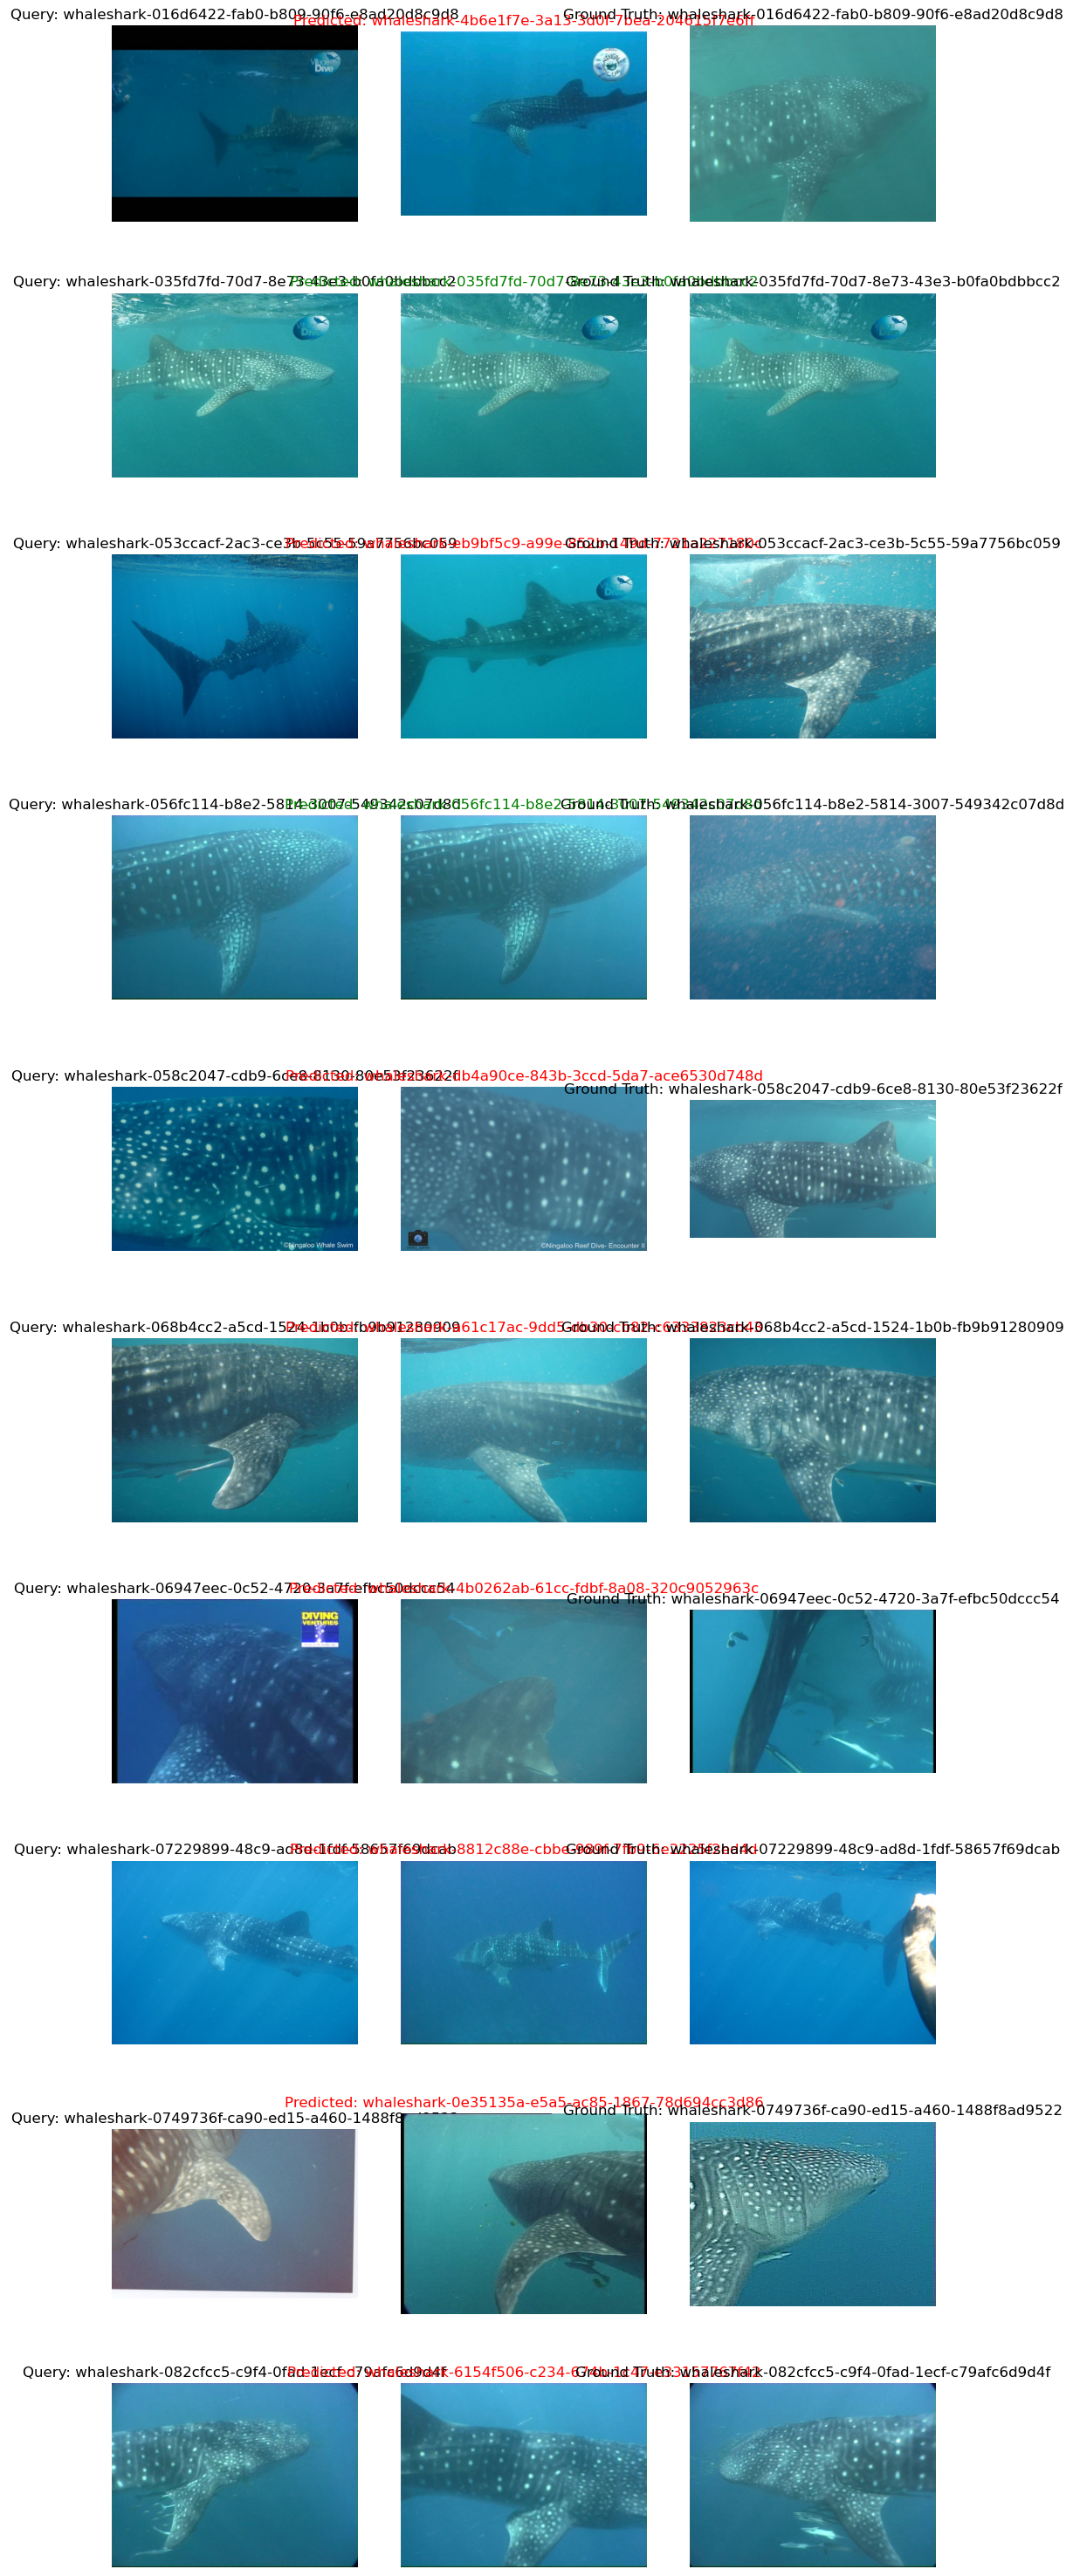

In [9]:
# print predictions for the multi species task
filtered_query = dataset_query_P.metadata[query_mask]
filtered_database = dataset_database_P.metadata[database_mask]

query_prediction_results_similarity(
    root=config['dataset'],
    query_metadata=filtered_query,
    db_metadata=filtered_database,
    query_start=0,
    similarity_scores=species_similarity['cosine'],
    num_images=10
)

In [23]:
query_labels

array(['ATRW-0', 'ATRW-1', 'ATRW-10', 'ATRW-100', 'ATRW-102', 'ATRW-103',
       'ATRW-105', 'ATRW-106', 'ATRW-108', 'ATRW-109', 'ATRW-111',
       'ATRW-112', 'ATRW-114', 'ATRW-115', 'ATRW-117', 'ATRW-118',
       'ATRW-12', 'ATRW-120', 'ATRW-121', 'ATRW-123', 'ATRW-124',
       'ATRW-126', 'ATRW-127', 'ATRW-129', 'ATRW-13', 'ATRW-130',
       'ATRW-132', 'ATRW-133', 'ATRW-135', 'ATRW-136', 'ATRW-138',
       'ATRW-139', 'ATRW-141', 'ATRW-142', 'ATRW-144', 'ATRW-145',
       'ATRW-147', 'ATRW-148', 'ATRW-15', 'ATRW-150', 'ATRW-151',
       'ATRW-153', 'ATRW-154', 'ATRW-156', 'ATRW-157', 'ATRW-159',
       'ATRW-16', 'ATRW-160', 'ATRW-162', 'ATRW-163', 'ATRW-165',
       'ATRW-166', 'ATRW-168', 'ATRW-169', 'ATRW-171', 'ATRW-172',
       'ATRW-174', 'ATRW-175', 'ATRW-177', 'ATRW-178', 'ATRW-18',
       'ATRW-180', 'ATRW-181', 'ATRW-183', 'ATRW-184', 'ATRW-186',
       'ATRW-187', 'ATRW-189', 'ATRW-19', 'ATRW-190', 'ATRW-192',
       'ATRW-193', 'ATRW-195', 'ATRW-196', 'ATRW-198', 'ATRW-

In [11]:
print(predictions_P)

['ATRW-1' 'ATRW-1' 'ATRW-10' 'ATRW-100' 'ATRW-102' 'ATRW-103' 'ATRW-105'
 'ATRW-85' 'ATRW-108' 'ATRW-109' 'ATRW-111' 'ATRW-112' 'ATRW-114'
 'ATRW-115' 'ATRW-117' 'ATRW-118' 'ATRW-12' 'ATRW-120' 'ATRW-121'
 'ATRW-123' 'ATRW-124' 'ATRW-126' 'ATRW-127' 'ATRW-129' 'ATRW-13'
 'ATRW-130' 'ATRW-132' 'ATRW-133' 'ATRW-135' 'ATRW-136' 'ATRW-138'
 'ATRW-139' 'ATRW-141' 'ATRW-142' 'ATRW-144' 'ATRW-145' 'ATRW-147'
 'ATRW-148' 'ATRW-15' 'ATRW-150' 'ATRW-151' 'ATRW-153' 'ATRW-154'
 'ATRW-156' 'ATRW-157' 'ATRW-159' 'ATRW-16' 'ATRW-160' 'ATRW-162'
 'ATRW-163' 'ATRW-165' 'ATRW-166' 'ATRW-168' 'ATRW-169' 'ATRW-168'
 'ATRW-172' 'ATRW-174' 'ATRW-175' 'ATRW-177' 'ATRW-178' 'ATRW-18'
 'ATRW-180' 'ATRW-181' 'ATRW-183' 'ATRW-184' 'ATRW-186' 'ATRW-187'
 'ATRW-189' 'ATRW-19' 'ATRW-190' 'ATRW-192' 'ATRW-193' 'ATRW-195'
 'ATRW-195' 'ATRW-199' 'ATRW-216' 'ATRW-190' 'ATRW-204' 'ATRW-205'
 'ATRW-189' 'ATRW-202' 'ATRW-21' 'ATRW-210' 'ATRW-202' 'ATRW-213'
 'ATRW-214' 'ATRW-217' 'ATRW-219' 'ATRW-22' 'ATRW-220' 'ATRW-219

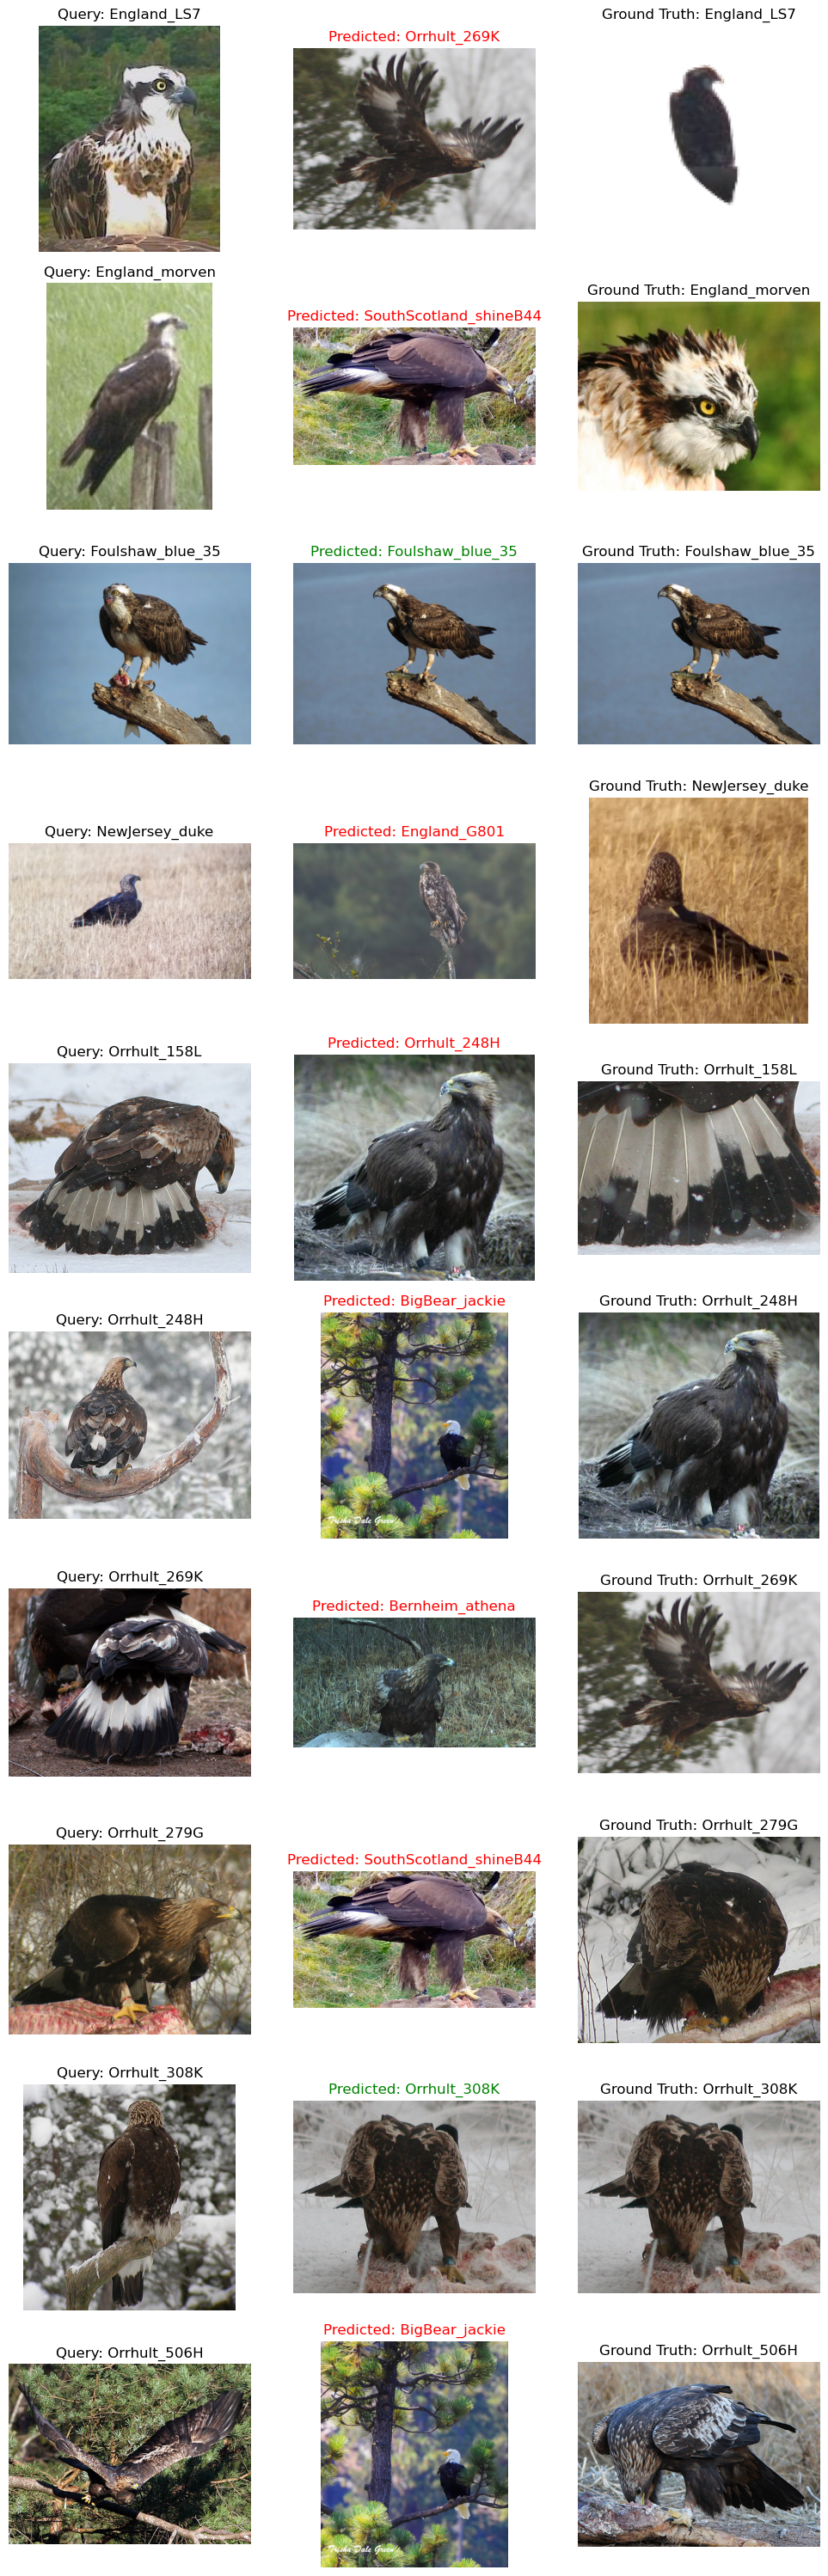

In [5]:
# prediction for dataset with just one species
query_prediction_results_similarity(
    root=config['dataset'],
    query_metadata=dataset_query_P.metadata,
    db_metadata=dataset_database_P.metadata,
    query_start=20,
    similarity_scores=similarity_P['cosine'],
    num_images=10
)